## Reversionspendel

In [2]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [4]:
A = loadtxt('./versuch1.csv', delimiter=',', skiprows=1,
           converters=dict(zip([2, 4], [lambda s: NaN if s==b'' else float(s)]*2)))
n, T1, dev_T1, T2, dev_T2 = transpose(A)

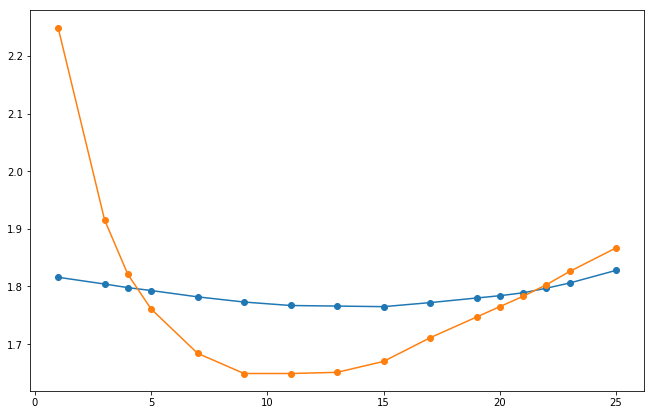

In [7]:
plt.plot(n, transpose([T1, T2]), 'o-')

<Container object of 3 artists>

<Container object of 3 artists>

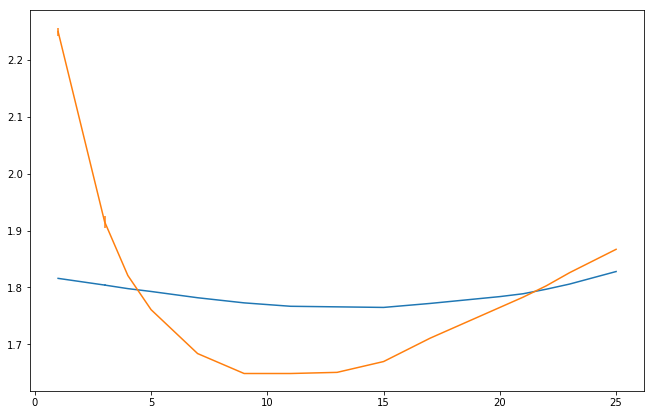

In [14]:
plt.errorbar(n, T1, dev_T1)
plt.errorbar(n, T2, dev_T2)